In [1]:
import os, random, torch
import cv2
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from PIL import Image
from multiprocessing import Manager as SharedMemoryManager
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
from torchvision.models.resnet import ResNet, BasicBlock
from typing import Optional, Union, Iterable, Tuple

In [2]:
# Config Parameters
data_dir = '/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebA-HQ-img'
epochs = 150
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_channels = 3
first_fmap_channels = 64
last_fmap_channels = 512
output_channels = 3
time_embedding = 256
learning_rate = 1e-3
min_lr = 1e-6
weight_decay = 0.0
n_timesteps = 500
beta_min = 1e-4
beta_max = 2e-2
beta_scheduler = 'linear'
batch_size = 8
image_size = (128, 128)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

number of images: 30000


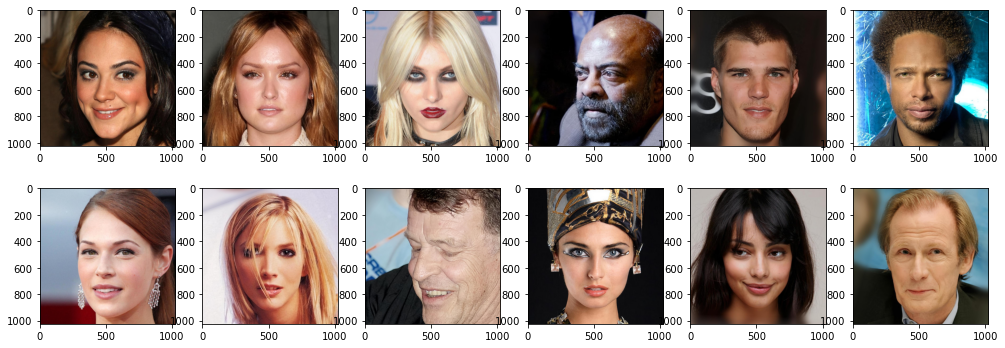

In [3]:
#load samples
files = os.listdir(data_dir)

print(f'number of images: {len(files)}')

n_rows, n_cols = 2, 6
fig, axs = plt.subplots(n_rows, n_cols, figsize=(17, 6))

for i in range(n_rows):
    for j in range(n_cols):
        idx = random.randint(0, len(files))
        img = Image.open(os.path.join(data_dir, f'{files[idx]}'))
        axs[i, j].imshow(img)

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out

In [5]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, image_size):
        self.img_dir = img_dir
        self.image_size = image_size
        self.files = os.listdir(self.img_dir)[:5000]
        
        self.transforms = transforms.Compose([
            transforms.Resize(self.image_size), 
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        
    def __len__(self):
        return len(self.files)
                
    def __getitem__(self, idx):
        file_path = os.path.join(self.img_dir, self.files[idx])
        image = Image.open(file_path)
        if self.transforms:
            image = self.transforms(image)
        return image

shape: torch.Size([3, 128, 128])
min pixel value: -0.9921568632125854
mean pixel value: -0.16029377281665802
max pixel value: 0.6705882549285889


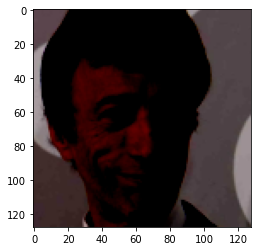

In [6]:
dataset = ImageDataset(data_dir, image_size)
sample_img = dataset[0]

print(f'shape: {sample_img.shape}')
print(f'min pixel value: {sample_img.min()}')
print(f'mean pixel value: {sample_img.mean()}')
print(f'max pixel value: {sample_img.max()}')

plt.imshow(sample_img.permute(1, 2, 0))

# The Diffusion Process

The diffusion process consists of two parts, the forward process and the backward process, and both processes are on a single Markov chain.


## The Forward Process
In the **forward process**, noise is sampled from a normal gaussian distribution, this noise is then added to a sample image gradually in each timestep of the Markov chain. Mathematically, given an image $x_0$ and a noise $\epsilon$, such that $\epsilon$~$N(\mu, I)$, given a Markov chain that spans $T$ timesteps, from $t=0$ to $t=T-1$, then the forward process $q$ can be defined as:
$$q(x_{t+1}|x_{t}) = N(x_{t+1}; (\sqrt{1-\beta_{t+1}}) x_t, \beta_{t+1}I)$$

where:
$\beta$ is a sequence of scheduled values defined by two hyper-parameters, $\beta_{min}$ and $\beta_{max}$. In the original DDPM paper, $\beta_{min}$ and $\beta_{max}$ were defined to be 0.0004 and 0.02 respectively. The values in the $\beta$ sequence correspond to each timestep in the markov chain. Assuming we have have a Markov chain with 3 timesteps:

at $t=0$, $x = x_0$   (The original image)

at $t=1$, $x = x_1 = q(x_1|x_0) = N(x_1; (\sqrt{1-\beta_{1}}) x_0, \beta_1I)$

at $t=2$, $x = x_2 = q(x_2|x_1) = N(x_2; (\sqrt{1-\beta_{2}}) x_1, \beta_2I)$

at $t=3$, $x = x_3 = q(x_3|x_2) = N(x_3; (\sqrt{1-\beta_{3}}) x_2, \beta_3I)$

Now, notice how the next timestep is only dependent on the immediate previous timestep, and nothing before, this is why the process chain is called a Markov chain.

Now, we understand how the images are noised in each timestep of the forward process. However, during training, iteratively adding noise to the images in this manner is computationally expensive and hence, will take a very long time to run just a single training step. To avoid this computational cost, we introduce a term $\alpha$, where $\alpha = 1 - \beta$. Now we can express the forward process interms of $\alpha$ like so:

$$q(x_{t+1}|x_t) = N(x_{t+1}; (\sqrt{\alpha_{t+1}}) x_t, (1-\alpha_{t+1})I)$$

Now, here comes the good part, assuming we have a sequence of $\alpha$ values, $\{\alpha_0, \alpha_1, \alpha_2, \alpha_3, ... \alpha_{T-1}\}$ we can derive a term $\hat{\alpha}$, where $\hat{\alpha}$ is a sequence of the cummulative product of the terms in $\{\alpha_0, \alpha_1, \alpha_2, \alpha_3, ... \alpha_T\}$, mathematically, $$\hat{\alpha} = \prod_{t=0}^{T-1} \alpha_t$$

So, inotherwords, the first term in the $\hat{\alpha}$ sequence will be $\hat{\alpha}_0 = \alpha_0$, the second term will be $\hat{\alpha}_1 = \alpha_0 . \alpha_1$, the T term will be $\hat{\alpha}_T = \alpha_0 . \alpha_1 . ... \alpha_T$.

The idea behind this is, if you want to apply noise to a given image up to a given timstep, you don't have to iteratively perform the computation, rather you can sample out the $\hat{\alpha}$ value for that given timestep $\hat{\alpha}_t$, and apply the noise with it to the image with the following formula:

$$x_t := \sqrt{\hat{\alpha}_t}.x_0 + \sqrt{1-\hat{\alpha}_t}.\epsilon$$

And that is basically all their is to the forward process of the DDPM. *You can see all these play out in the `noiseImage` method of the `DiffusionUtils` class in the code cell below.*

Now, pertaining how the $\beta$ values are generated, these values can be generated by linear or cosine scheduling from $\beta_{min}$ to $\beta_{max}$. 

For linear scheduling, $\beta_t$ is given as:

$$\beta_t = \beta_{min} + t\frac{\beta_{max} - \beta_{min}} {T}$$

and the cosine scheduling will be given as:

$$\beta_t = \beta_{min} + 0.5(\beta_{max} - \beta_{min}) (1 - \cos{\frac {t} {T}\pi})$$

Where $t$ ~ $Uniform(0, T-1)$

The beta scheduling is done in the `betaSamples` method of the `DiffusionUtils` class. Depending on how you intialise the class, you can either schedule with 'linear' or 'cosine' technique, by specifying 'linear' or 'cosine' as the `scheduler` argument of the class `__init__` method. You can also pass the number of timesteps with the `n_timesteps` argument, as well as $beta_{min}$ and $beta_{max}$ with the `beta_min` and `beta_max` argument respectively.

**Note:** In this explaination, all indexing started from 0 ($t=0$) and ends at $T-1$, unlike in the original paper where indexing beings at 1 ($t=1$) and ends with T. This is because we will be programming these mathematical functionalities, and in programming, computers start indexing a sequence at 0. So in the original paper, you might see the forward expression as: $q(x_t|x_{t-1}) = N(x_t; (\sqrt{1-\beta_t}) x_{t-1}, \beta_tI)$, where  $t$ ~ $Uniform(1, T)$, which is equivalent to the expression in this notebook.

# The Backward Process

The backward process is the opposite of the forward process, in the sense that we attempt to reverse the noising of the forward process, inotherwords, we attempt to denoise, so as to get the inital image at the first timestep $t=0$, from the last timestep of the forward process $t=T-1$. One thing to note is that at the end of the forward process, it is assumed that $x_{T-1}$ is almost identical to pure noise sampled from a normal gaussian distribution, hence you could say; ($x_{T-1}$ ~ $N(\mu, I)$). This is very intuitive, because by the time the parameterized model that is responsible for denoising in the backward process, learns to successfully convert a sample from $x_{T-1}$ to $x_0$, the model would more or less be able to generate real images from a data distribution, merely from pure random noise sampled from a normal gaussian distribution.

In the backward process, we have a parameterized model (a neural network model), this model is responsible for predicting the entire noise added to the image. When the model predicts a noise, a portion of that predicted noise is removed form the image, depending the given timestep. The parameterized model takes in two inputs, the noised image and the corresponding timestep of the Markov chain, and predicts the noise added to the image. 

If we denote backward process as $p$, then $p$ can be mathematically expressed as:

$$p(x_t | x_{t+1}) = N(x_t; \mu(x_{t+1}, t+1), {\sigma_0(x_{t+1}, t+1)}^2)$$

Where, $\mu(x_{t+1}, t+1)$ and ${\sigma_0(x_{t+1}, t+1)}^2$ are the mean and variance of the predicted noise $\epsilon(x_{t+1}, t+1))$.

Now, let us express this in a more understandable way to get the intuition behind it. We've expressed the backward process mathematically, what exactly is the expression for $x_t$, given $x_{t+1}$? Well, the expression is simply the reverse of the expression of the forward process, except now, the noise being removed is the noise that the model predicted. The expression is as follows:

$$x_t = \frac 1 {\sqrt{\alpha_{t+1}}} (x_{t+1} - \frac {1-\alpha_{t+1}} {\sqrt{1 - \hat{\alpha}_{t+1}}} \epsilon(x_{t+1}, t+1)) + \sigma_{t+1} z$$

Where $\sigma_t = \sqrt{\beta_t}$ : (standard deviation of noise) and $z$~$N(0, I)$.

And that is pretty much it for the backward process.

Now, one thing to note is that for $t=0$, $z$ is set to 0, this is because at $t=0$, $x_t = x_0$ which the original image without noise, hence their is no need adding the $z$ term to it.

You can see all these play out in the `sample` method of the `DiffusionUtils` class, that takes in a batch of sampled noise and the trained model as arguments.

The `sampleTimestep` method randomly samples a batch of timsteps from 1 to $T$ (`n_timesteps`). This way, the sample image does not have to be completely noised all the way to the final timestep $T$ before the model can train, the model just needs to be able to perform denoising at any given timestep.

In the later sections, we will discuss about how the model keeps track of timesteps, via the transformer sinusoidal embedding.

The cell below is the full code of the diffusion processes.

In [7]:
class DiffusionUtils:
    def __init__(self, n_timesteps, beta_min, beta_max, device='cuda', scheduler='linear'):
        assert scheduler in ['linear', 'cosine'], 'scheduler must be linear or cosine'

        self.n_timesteps = n_timesteps
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.device = device
        self.scheduler = scheduler
        
        self.betas = self.betaSamples()
        self.alphas = 1 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)
    
    
    def betaSamples(self):
        if self.scheduler == 'linear':
            return torch.linspace(start=self.beta_min, end=self.beta_max, steps=self.n_timesteps).to(self.device)

        elif self.scheduler == 'cosine':
            betas = []
            for i in reversed(range(self.n_timesteps)):
                T = self.n_timesteps - 1
                beta = self.beta_min + 0.5*(self.beta_max - self.beta_min) * (1 + np.cos((i/T) * np.pi))
                betas.append(beta)
                
            return torch.Tensor(betas).to(self.device)
    
    
    def sampleTimestep(self, size):
        return torch.randint(low=1, high=self.n_timesteps, size=(size, )).to(self.device)
    
    
    def noiseImage(self, x, t):
        assert len(x.shape) == 4, 'input must be 4 dimensions'
        alpha_hat_sqrts = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        one_mins_alpha_hat_sqrt = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        noise = torch.randn_like(x).to(self.device)
        return (alpha_hat_sqrts * x) + (one_mins_alpha_hat_sqrt * noise), noise
    
    def sample(self, x, model):
        assert len(x.shape) == 4, 'input must be 4 dimensions'
        model.eval()
        
        with torch.no_grad():
            iterations = range(1, self.n_timesteps)
            for i in tqdm(reversed(iterations)):
                #batch of timesteps t
                t = (torch.ones(x.shape[0]) * i).long().to(self.device)
                
                #params
                alpha = self.alphas[t][:, None, None, None]
                beta = self.betas[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                one_minus_alpha = 1 - alpha
                one_minus_alpha_hat = 1 - alpha_hat
                
                #predict noise pertaining for a given timestep
                predicted_noise = model(x, t)
                
                if i > 1:noise = torch.randn_like(x).to(self.device)
                else:noise = torch.zeros_like(x).to(self.device)
                
                x = 1/torch.sqrt(alpha) * (x - ((one_minus_alpha / torch.sqrt(one_minus_alpha_hat)) * predicted_noise))
                x = x + (torch.sqrt(beta) * noise)
            return x

linear beta scheduling...


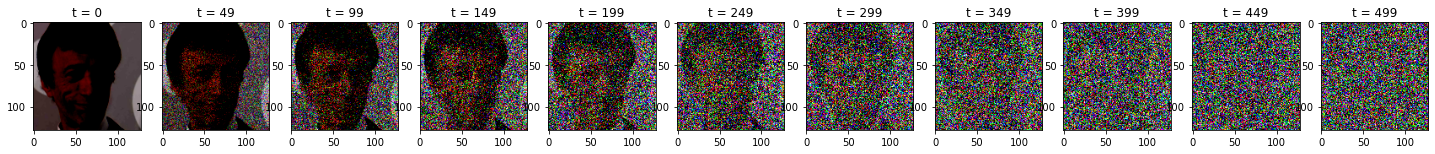



cosine beta scheduling...


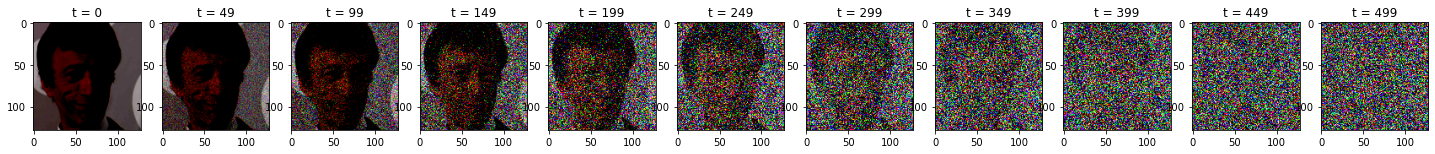

In [8]:
T = n_timesteps
n_steps = 50
alpha_values = {}

for scheduler in ['linear', 'cosine']:
    print(f'{scheduler} beta scheduling...')

    diffusion = DiffusionUtils(T, beta_min, beta_max, device=DEVICE, scheduler=scheduler)
    alpha_values[scheduler] = diffusion.alphas.cpu()

    fig, axs = plt.subplots(1, (T//n_steps)+1, figsize=(25, 15))

    axs[0].imshow(sample_img.permute(1, 2, 0))
    axs[0].set_title('t = 0')

    for idx, t in enumerate(range(n_steps-1, T, n_steps)):
        t = torch.Tensor([t]).long()
        x, _ = diffusion.noiseImage(sample_img.unsqueeze(0).to(DEVICE), t)
        axs[idx+1].imshow(x.squeeze(0).permute(1, 2, 0).cpu())
        axs[idx+1].set_title(f't = {t.item()}')
    plt.show()
    print('\n')

Text(0.5, 1.0, 'alpha values of cosine scheduling')

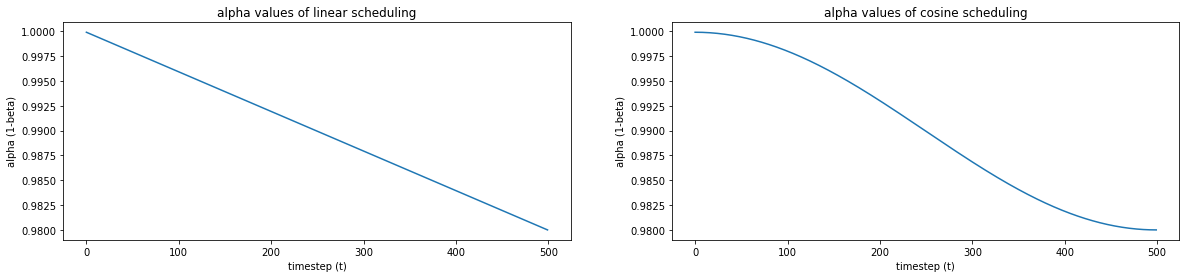

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))

axs[0].plot(alpha_values['linear'])
axs[0].set_xlabel('timestep (t)')
axs[0].set_ylabel('alpha (1-beta)')
axs[0].set_title('alpha values of linear scheduling')

axs[1].plot(alpha_values['cosine'])
axs[1].set_xlabel('timestep (t)')
axs[1].set_ylabel('alpha (1-beta)')
axs[1].set_title('alpha values of cosine scheduling')

In [10]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, dim_size, n:int=10000):
        assert dim_size % 2 == 0, 'dim_size should be an even number'
            
        super(SinusoidalEmbedding, self).__init__()
        
        self.dim_size = dim_size
        self.n = n
        
    def forward(self, x:torch.Tensor):
        N = len(x)
        output = torch.zeros(size=(N, self.dim_size)).to(x.device)
        
        for idx in range(0, N):
            for i in range(0, self.dim_size//2):
                emb = x[idx] / (self.n ** (2*i / self.dim_size))
                output[idx, 2*i] = torch.sin(emb)
                output[idx, (2*i) + 1] = torch.cos(emb)
        
        return output

In [11]:
class ImageSelfAttention(nn.Module):
    def __init__(self, input_channels:int, n_heads:int):
        super(ImageSelfAttention, self).__init__()
        
        self.input_channels = input_channels
        self.n_heads = n_heads
        self.layernorm = nn.LayerNorm(self.input_channels)
        self.attention = nn.MultiheadAttention(self.input_channels, self.n_heads, batch_first=True)
        
    def forward(self, x:torch.Tensor):
        # shape of x: (N, C, H, W)
        _, C, H, W = x.shape
        x = x.reshape(-1, C, H*W).permute(0, 2, 1)
        normalised_x = self.layernorm(x)
        attn_val, _ = self.attention(normalised_x, normalised_x, normalised_x)
        attn_val = attn_val + x
        attn_val = attn_val.permute(0, 2, 1).reshape(-1, C, H, W)
        return attn_val

In [12]:
class Encoder(ResNet):
    def __init__(
        self, input_channels:int, time_embedding:int, 
        block=BasicBlock, block_layers:list=[2, 2, 2, 2], n_heads:int=4):
      
        self.block = block
        self.block_layers = block_layers
        self.time_embedding = time_embedding
        self.input_channels = input_channels
        self.n_heads = n_heads
        
        super(Encoder, self).__init__(self.block, self.block_layers)
        
        #time embedding layer
        self.sinusiodal_embedding = SinusoidalEmbedding(self.time_embedding)
        
        fmap_channels = [64, 64, 128, 256, 512]
        #layers to project time embeddings unto feature maps
        self.time_projection_layers = self.make_time_projections(fmap_channels)
        #attention layers for each feature map
        self.attention_layers = self.make_attention_layers(fmap_channels)
        
        self.conv1 = nn.Conv2d(
            self.input_channels, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), 
            bias=False)
        
        self.conv2 = nn.Conv2d(
            64, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3),
            bias=False)

        #delete unwanted layers
        del self.maxpool, self.fc, self.avgpool
        
        
    def forward(self, x:torch.Tensor, t:torch.Tensor):
        #embed time positions
        t = self.sinusiodal_embedding(t)
        
        #prepare fmap2
        fmap1 = self.conv1(x)
        t_emb = self.time_projection_layers[0](t)
        fmap1 = fmap1 + t_emb[:, :, None, None]
        fmap1 = self.attention_layers[0](fmap1)
        
        x = self.conv2(fmap1)
        x = self.bn1(x)
        x = self.relu(x)
        
        #prepare fmap2
        fmap2 = self.layer1(x)
        t_emb = self.time_projection_layers[1](t)
        fmap2 = fmap2 + t_emb[:, :, None, None]
        fmap2 = self.attention_layers[1](fmap2)
        
        #prepare fmap3
        fmap3 = self.layer2(fmap2)
        t_emb = self.time_projection_layers[2](t)
        fmap3 = fmap3 + t_emb[:, :, None, None]
        fmap3 = self.attention_layers[2](fmap3)
        
        #prepare fmap4
        fmap4 = self.layer3(fmap3)
        t_emb = self.time_projection_layers[3](t)
        fmap4 = fmap4 + t_emb[:, :, None, None]
        fmap4 = self.attention_layers[3](fmap4)
        
        #prepare fmap4
        fmap5 = self.layer4(fmap4)
        t_emb = self.time_projection_layers[4](t)
        fmap5 = fmap5 + t_emb[:, :, None, None]
        fmap5 = self.attention_layers[4](fmap5)
        
        return fmap1, fmap2, fmap3, fmap4, fmap5
    
    
    def make_time_projections(self, fmap_channels:Iterable[int]):
        layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(self.time_embedding, ch)
            ) for ch in fmap_channels ])
        
        return layers
    
    def make_attention_layers(self, fmap_channels:Iterable[int]):
        layers = nn.ModuleList([
            ImageSelfAttention(ch, self.n_heads) for ch in fmap_channels
        ])
        
        return layers

In [13]:
class DecoderBlock(nn.Module):
    def __init__(
        self, input_channels:int, output_channels:int, 
        time_embedding:int, upsample_scale:int=2, activation:nn.Module=nn.ReLU,
        compute_attn:bool=True, n_heads:int=4):
        super(DecoderBlock, self).__init__()

        self.input_channels = input_channels
        self.output_channels = output_channels
        self.upsample_scale = upsample_scale
        self.time_embedding = time_embedding
        self.compute_attn = compute_attn
        self.n_heads = n_heads
        
        #attention layer
        if self.compute_attn:
            self.attention = ImageSelfAttention(self.output_channels, self.n_heads)
        else:self.attention = nn.Identity()
        
        #time embedding layer
        self.sinusiodal_embedding = SinusoidalEmbedding(self.time_embedding)
        
        #time embedding projection layer
        self.time_projection_layer = nn.Sequential(
                nn.SiLU(),
                nn.Linear(self.time_embedding, self.output_channels)
            )

        self.transpose = nn.ConvTranspose2d(
            self.input_channels, self.input_channels, 
            kernel_size=self.upsample_scale, stride=self.upsample_scale)
        
        self.instance_norm1 = nn.InstanceNorm2d(self.transpose.in_channels)

        self.conv = nn.Conv2d(
            self.transpose.out_channels, self.output_channels, kernel_size=3, stride=1, padding=1)
        
        self.instance_norm2 = nn.InstanceNorm2d(self.conv.out_channels)
        
        self.activation = activation()

    
    def forward(self, fmap:torch.Tensor, prev_fmap:Optional[torch.Tensor]=None, t:Optional[torch.Tensor]=None):
        output = self.transpose(fmap)
        output = self.instance_norm1(output)
        output = self.conv(output)
        output = self.instance_norm2(output)
        
        #apply residual connection with previous feature map
        if torch.is_tensor(prev_fmap):
            assert (prev_fmap.shape == output.shape), 'feature maps must be of same shape'
            output = output + prev_fmap
            
        #apply timestep embedding
        if torch.is_tensor(t):
            t = self.sinusiodal_embedding(t)
            t_emb = self.time_projection_layer(t)
            output = output + t_emb[:, :, None, None]
            
            output = self.attention(output)
            
        output = self.activation(output)
        return output

In [14]:
class Decoder(nn.Module):
    def __init__(
        self, last_fmap_channels:int, output_channels:int, 
        time_embedding:int, first_fmap_channels:int=64, n_heads:int=4):
        super(Decoder, self).__init__()
        
        self.last_fmap_channels = last_fmap_channels
        self.output_channels = output_channels
        self.time_embedding = time_embedding
        self.first_fmap_channels = first_fmap_channels
        self.n_heads = n_heads

        self.residual_layers = self.make_layers()

        self.final_layer = DecoderBlock(
            self.residual_layers[-1].input_channels, self.output_channels,
            time_embedding=self.time_embedding, activation=nn.Identity, 
            compute_attn=False, n_heads=self.n_heads)

        #set final layer second instance norm to identity
        self.final_layer.instance_norm2 = nn.Identity()


    def forward(self, *fmaps, t:Optional[torch.Tensor]=None):
        #fmaps(reversed): fmap5, fmap4, fmap3, fmap2, fmap1
        fmaps = [fmap for fmap in reversed(fmaps)]
        ouptut = None
        for idx, m in enumerate(self.residual_layers):
            if idx == 0:
                output = m(fmaps[idx], fmaps[idx+1], t)
                continue
            output = m(output, fmaps[idx+1], t)
        
        # no previous fmap is passed to the final decoder block
        # and no attention is computed
        output = self.final_layer(output)
        return output

      
    def make_layers(self, n:int=4):
        layers = []
        for i in range(n):
            if i == 0: in_ch = self.last_fmap_channels
            else: in_ch = layers[i-1].output_channels

            out_ch = in_ch // 2 if i != (n-1) else self.first_fmap_channels
            layer = DecoderBlock(
                in_ch, out_ch, 
                time_embedding=self.time_embedding,
                compute_attn=True, n_heads=self.n_heads)
            
            layers.append(layer)

        layers = nn.ModuleList(layers)
        return layers

In [15]:
class DiffusionNet(nn.Module):
    def __init__(self, encoder:Encoder, decoder:Decoder):
        
        super(DiffusionNet, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x:torch.Tensor, t:torch.Tensor):
        enc_fmaps = self.encoder(x, t=t)
        segmentation_mask = self.decoder(*enc_fmaps, t=t)
        return segmentation_mask

# Training Pipeline

The training pipeline class is fairly straight forward, it takes in the model, loss function, optimizer and diffusion utils objects as input alongside other arugments like device and weight initialisation...

The network weights are initialised with the `xavier_init_weight` or the `custom_weight_initializer`, when `weight_init` is True. The `save_model` method as the name implies is responsible for saving the model and optimization weights. The `train` method is where the model trains, it takes the dataloader as argument and loads the data in batches for training. In the training method, we sample a batch of timesteps $t$ with the `sampleTimestep` method of the `diffusion_utils` opbject, then for each of those timesteps, we compute the a batch of noised images with the `noiseImage` method, this method also returns the batch of noise alongside the noised images. The noised images are sent into the model alongside their corresponding timesteps, the output of the model is then compared to the noise added to the image via mean square error metric. Finally, the model gradients are computed by partially differentiating the MSE loss expression with respect to the model weights and then the model weights are computed, and so on...

In [16]:
class Trainer:
    def __init__(self, model, lossfunc, optimizer,scheduler, diffusion_utils, 
                 device='cuda', pretrained = False, weight_init=True):
        
        self.device = device
        self.model = model.to(self.device)
        self.lossfunc = lossfunc
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.weight_init = weight_init
        self.diffusion_utils = diffusion_utils
        self.best_loss = None
        if self.weight_init:
            self.model.apply(self.xavier_init_weights)
        if pretrained:
            self.load()

    def xavier_init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.xavier_uniform_(m.weight)
            if torch.is_tensor(m.bias):
                m.bias.data.fill_(0.01)
    
    def save(self,loss):
        state = {
            "state_dict": self.model.state_dict(),
            "optimizer": self.optimizer.state_dict(),
        }
        if self.best_loss == None:
            self.best_loss = loss
            torch.save(state, "ddpm_model.pth")
            print("=>Checkpoint Saved")
        elif loss <= self.best_loss:
            self.best_loss = loss
            torch.save(state, "ddpm_model.pth")
            print("=>Checkpoint Saved")
            
    def load(self):
        print("=> Loading checkpoint")
        checkpoint = torch.load("/kaggle/input/ddpm-pretrained/ddpm_model.pth",map_location=torch.device(DEVICE))
        self.model.load_state_dict(checkpoint["state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer"])
        

    def train(self, dataloader, epoch, verbose=False):
        self.model.train()
        loss = 0
        for idx, images in enumerate(tqdm(dataloader)):
            self.model.zero_grad()
            images = images.to(self.device)
            t = self.diffusion_utils.sampleTimestep(size=images.shape[0])
            x_t, noise = self.diffusion_utils.noiseImage(images, t)
            pred_noise = self.model(x_t, t)
            batch_loss = self.lossfunc(pred_noise, noise)
            batch_loss.backward()
            self.optimizer.step()
            loss += batch_loss.item()
            
        loss = loss / (idx + 1)
        self.save(loss)
        self.scheduler.step()
        if verbose:
            print(f'Epoch[{epoch}]: Training Loss: {loss}')

        return loss
    
    def addNoiseandDenoisewithAndWithoutMask(self,tback,image,originalImage,mask):
        mask = cv2.resize(mask,(128,128),interpolation=cv2.INTER_NEAREST)
        image = cv2.resize(image,(128,128),interpolation=cv2.INTER_AREA)
        imgTransforms = transforms.Compose([
                transforms.Resize((128,128)), 
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        images = Image.fromarray(image)
        images = imgTransforms(images)
        images = torch.unsqueeze(images, 0)
        mask = torch.unsqueeze(torch.tensor(mask), 0).to(self.device)
        t = (torch.ones(images.shape[0])*tback).long().to(self.device)
        x_t, _ = self.diffusion_utils.noiseImage(images.to(self.device), t)
        x_t_masked, _ = self.diffusion_utils.noiseImage(images.to(self.device), t)
        noisyImages = x_t.cpu()
        noisyImages = (noisyImages.clamp(-1, 1) + 1) / 2
        n = images.shape[0]
        noisyImages = noisyImages[0].permute(1, 2, 0).numpy() * 255
        noisyImages = noisyImages.astype(np.uint8)
        self.model.eval()
        with torch.no_grad():
            iterations = range(1, tback)
            for i in tqdm(reversed(iterations)):
                #batch of timesteps t
                t = (torch.ones(x_t.shape[0]) * i).long().to(self.device)
                t_1 = (torch.ones(x_t.shape[0]) * (i-1)).long().to(self.device)
                #params
                alpha = self.diffusion_utils.alphas[t][:, None, None, None]
                beta = self.diffusion_utils.betas[t][:, None, None, None]
                alpha_hat = self.diffusion_utils.alpha_hat[t][:, None, None, None]
                one_minus_alpha = 1 - alpha
                one_minus_alpha_hat = 1 - alpha_hat
                
                #predict noise pertaining for a given timestep
                predicted_noise = self.model(x_t, t)
                predicted_noise_masked = self.model(x_t_masked, t)
                
                if i > 1:
                    noise = torch.randn_like(x_t).to(self.device)
                else:
                    noise = torch.zeros_like(x_t).to(self.device)
                
                x_t = 1/torch.sqrt(alpha) * (x_t - ((one_minus_alpha / torch.sqrt(one_minus_alpha_hat)) * predicted_noise))
                x_t = x_t + (torch.sqrt(beta) * noise)
                
                x_t_masked = 1/torch.sqrt(alpha) * (x_t_masked - ((one_minus_alpha / torch.sqrt(one_minus_alpha_hat)) * predicted_noise_masked))
                x_t_masked = x_t_masked + (torch.sqrt(beta) * noise)
                
                if i > 20:
                    x_t_masked = x_t_masked*mask + (1-mask)*self.diffusion_utils.noiseImage(images.to(self.device), t_1)[0]
                    
        x_t = x_t.cpu()
        x_t = (x_t.clamp(-1, 1) + 1) / 2

        img = x_t[0].permute(1, 2, 0).numpy() * 255
        img = img.astype(np.uint8)
        
        x_t_masked = x_t_masked.cpu()
        x_t_masked = (x_t_masked.clamp(-1, 1) + 1) / 2

        img_masked = x_t_masked[0].permute(1, 2, 0).numpy() * 255
        img_masked = img_masked.astype(np.uint8)
        
        fig, axs = plt.subplots(1, 5, figsize=(24,6))
        axs[0].imshow(originalImage)
        axs[0].set_xticks([])
        axs[0].set_yticks([])
        axs[1].imshow(image)
        axs[1].set_xticks([])
        axs[1].set_yticks([])
        axs[2].imshow(noisyImages)
        axs[2].set_xticks([])
        axs[2].set_yticks([])
        axs[3].imshow(img)
        axs[3].set_xticks([])
        axs[3].set_yticks([])
        axs[4].imshow(img_masked)
        axs[4].set_xticks([])
        axs[4].set_yticks([])
        plt.show()
    
    def addNoiseandMaskedDenoise(self,tback,image,mask):
        mask = cv2.resize(mask,(128,128),interpolation=cv2.INTER_NEAREST)
        image = cv2.resize(image,(128,128),interpolation=cv2.INTER_AREA)
        plt.imshow(image)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.savefig("PaintedImage.png")
        plt.show()
        imgTransforms = transforms.Compose([
                transforms.Resize((128,128)), 
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        image = Image.fromarray(image)
        image = imgTransforms(image)
        images = torch.unsqueeze(image, 0)
        mask = torch.unsqueeze(torch.tensor(mask), 0).to(self.device)
        t = (torch.ones(images.shape[0])*tback).long().to(self.device)
        x_t, _ = self.diffusion_utils.noiseImage(images.to(self.device), t)
        noisyImages = x_t.cpu()
        noisyImages = (noisyImages.clamp(-1, 1) + 1) / 2
        n = images.shape[0]
        img = noisyImages[0].permute(1, 2, 0).numpy() * 255
        img = img.astype(np.uint8)
        plt.imshow(img)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.savefig("NoisyImages.png")
        plt.show()
        self.model.eval()
        with torch.no_grad():
            iterations = range(1, tback)
            for i in tqdm(reversed(iterations)):
                #batch of timesteps t
                t = (torch.ones(x_t.shape[0]) * i).long().to(self.device)
                t_1 = (torch.ones(x_t.shape[0]) * (i-1)).long().to(self.device)
                #params
                alpha = self.diffusion_utils.alphas[t][:, None, None, None]
                beta = self.diffusion_utils.betas[t][:, None, None, None]
                alpha_hat = self.diffusion_utils.alpha_hat[t][:, None, None, None]
                one_minus_alpha = 1 - alpha
                one_minus_alpha_hat = 1 - alpha_hat
                
                #predict noise pertaining for a given timestep
                predicted_noise = self.model(x_t, t)
                
                if i > 1:noise = torch.randn_like(x).to(self.device)
                else:noise = torch.zeros_like(x_t).to(self.device)
                
                x_t = 1/torch.sqrt(alpha) * (x_t - ((one_minus_alpha / torch.sqrt(one_minus_alpha_hat)) * predicted_noise))
                x_t = x_t + (torch.sqrt(beta) * noise)
                if i > 20:x_t = x_t*mask + (1-mask)*self.diffusion_utils.noiseImage(images.to(self.device), t_1)[0]
        x_t = x_t.cpu()
        x_t = (x_t.clamp(-1, 1) + 1) / 2

        img = x_t[0].permute(1, 2, 0).numpy() * 255
        img = img.astype(np.uint8)
        plt.imshow(img)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.savefig("DeNoisedImages.png")
        plt.show()
        return img
    
    def addNoiseandDenoise(self,tback,image):
        image = cv2.resize(image,(128,128),interpolation=cv2.INTER_AREA)
        plt.imshow(image)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.savefig("PaintedImage.png")
        plt.show()
        imgTransforms = transforms.Compose([
                transforms.Resize((128,128)), 
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        image = Image.fromarray(image)
        image = imgTransforms(image)
        images = torch.unsqueeze(image, 0)
            
        t = (torch.ones(images.shape[0])*tback).long().to(self.device)
        x_t, _ = self.diffusion_utils.noiseImage(images.to(self.device), t)
        noisyImages = x_t.cpu()
        noisyImages = (noisyImages.clamp(-1, 1) + 1) / 2
        n = images.shape[0]
        img = noisyImages[0].permute(1, 2, 0).numpy() * 255
        img = img.astype(np.uint8)
        plt.imshow(img)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.savefig("NoisyImages.png")
        plt.show()
        self.model.eval()
        with torch.no_grad():
            iterations = range(1, tback)
            for i in tqdm(reversed(iterations)):
                #batch of timesteps t
                t = (torch.ones(x_t.shape[0]) * i).long().to(self.device)
                
                #params
                alpha = self.diffusion_utils.alphas[t][:, None, None, None]
                beta = self.diffusion_utils.betas[t][:, None, None, None]
                alpha_hat = self.diffusion_utils.alpha_hat[t][:, None, None, None]
                one_minus_alpha = 1 - alpha
                one_minus_alpha_hat = 1 - alpha_hat
                
                #predict noise pertaining for a given timestep
                predicted_noise = self.model(x_t, t)
                
                if i > 1:noise = torch.randn_like(x_t).to(self.device)
                else:noise = torch.zeros_like(x_t).to(self.device)
                
                x_t = 1/torch.sqrt(alpha) * (x_t - ((one_minus_alpha / torch.sqrt(one_minus_alpha_hat)) * predicted_noise))
                x_t = x_t + (torch.sqrt(beta) * noise)
        x_t = x_t.cpu()
        x_t = (x_t.clamp(-1, 1) + 1) / 2

        img = x_t[0].permute(1, 2, 0).numpy() * 255
        img = img.astype(np.uint8)
        plt.imshow(img)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.savefig("DeNoisedImages.png")
        plt.show()
    
    def addNoiseandDenoiseBatch(self,tback,dataloader):
        for idx, images in enumerate(tqdm(dataloader)):
            break
            
        t = (torch.ones(images.shape[0])*tback).long().to(self.device)
        x_t, _ = self.diffusion_utils.noiseImage(images.to(self.device), t)
        noisyImages = x_t.cpu()
        noisyImages = (noisyImages.clamp(-1, 1) + 1) / 2
        n = images.shape[0]
        fig, axs = plt.subplots(1, n, figsize=(20,3))
        
        for i in range(n):
            img = noisyImages[i].permute(1, 2, 0).numpy() * 255
            img = img.astype(np.uint8)
            axs[i].imshow(img)
            axs[i].set_xticks([])
            axs[i].set_yticks([])
        plt.savefig("NoisyImages.png")
        plt.show()
        self.model.eval()
        with torch.no_grad():
            iterations = range(1, tback)
            for i in tqdm(reversed(iterations)):
                #batch of timesteps t
                t = (torch.ones(x_t.shape[0]) * i).long().to(self.device)
                
                #params
                alpha = self.diffusion_utils.alphas[t][:, None, None, None]
                beta = self.diffusion_utils.betas[t][:, None, None, None]
                alpha_hat = self.diffusion_utils.alpha_hat[t][:, None, None, None]
                one_minus_alpha = 1 - alpha
                one_minus_alpha_hat = 1 - alpha_hat
                
                #predict noise pertaining for a given timestep
                predicted_noise = self.model(x_t, t)
                
                if i > 1:noise = torch.randn_like(x_t).to(self.device)
                else:noise = torch.zeros_like(x_t).to(self.device)
                
                x_t = 1/torch.sqrt(alpha) * (x_t - ((one_minus_alpha / torch.sqrt(one_minus_alpha_hat)) * predicted_noise))
                x_t = x_t + (torch.sqrt(beta) * noise)
        x_t = x_t.cpu()
        x_t = (x_t.clamp(-1, 1) + 1) / 2

        fig, axs = plt.subplots(1, n, figsize=(20,3))
        
        for i in range(n):
            img = x_t[i].permute(1, 2, 0).numpy() * 255
            img = img.astype(np.uint8)
            axs[i].imshow(img)
            axs[i].set_xticks([])
            axs[i].set_yticks([])
        plt.savefig("DeNoisedImages.png")
        plt.show()
        
    
    def generate(self, epoch, n=4):
        x = torch.randn(n, 3, *image_size).to(self.device)
        generated_images = self.diffusion_utils.sample(x, self.model)
        generated_images = generated_images.cpu()
        generated_images = (generated_images.clamp(-1, 1) + 1) / 2

        fig, axs = plt.subplots(1, n, figsize=(12,3))
        
        for i in range(n):
            img = generated_images[i].permute(1, 2, 0).numpy() * 255
            img = img.astype(np.uint8)
            axs[i].imshow(img)
            axs[i].set_xticks([])
            axs[i].set_yticks([])
        plt.savefig("generation_{}.png".format(epoch))
        plt.show()

In [17]:
#train dataset and dataloader
train_dataset = ImageDataset(data_dir, image_size)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [18]:
#encoder, decoder model initialisation
encoder = Encoder(input_channels, time_embedding, block_layers=[2, 2, 2, 2])
decoder = Decoder(last_fmap_channels, output_channels, time_embedding, first_fmap_channels)
model = DiffusionNet(encoder, decoder)
seg_model = UNET(in_channels = 3 , out_channels = 11).to(DEVICE)
generator = GeneratorResNet().to(DEVICE)
generator.load_state_dict(torch.load("/kaggle/input/ddpm-pretrained/generator.pth"))
checkpoint = torch.load("/kaggle/input/ddpm-pretrained/checkpoint.pth",map_location=torch.device(DEVICE))
seg_model.load_state_dict(checkpoint["state_dict"])
seg_model = seg_model.eval()
generator = generator.eval()
#diffusion utilities class initialisaion
diffusion_utils = DiffusionUtils(n_timesteps, beta_min, beta_max, device, scheduler=beta_scheduler)

#loss function, optimizer and pipeline initialisation
lossfunc = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=epochs, eta_min=min_lr, verbose=True
)
trainer = Trainer(model, lossfunc, optimizer,scheduler, diffusion_utils, device=DEVICE, pretrained = True, weight_init=False)

Adjusting learning rate of group 0 to 1.0000e-03.
=> Loading checkpoint


In [19]:
# train_losses = []
# for epoch in range(epochs):
#     train_loss = trainer.train(train_dataloader, epoch, verbose=True)
#     train_losses.append(train_loss)
#     print(f'\ntraining loss: {train_loss}')
#     if epoch % 10 == 0:
#         print('generating samples...')
#         trainer.generate(epoch)

In [20]:
# trainer.generate(1,2)

In [21]:
IMAGE_HEIGHT = 384
IMAGE_WIDTH = 384
seg_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            ToTensorV2(),
        ],
    )

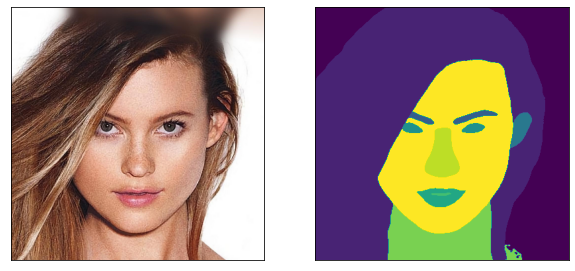

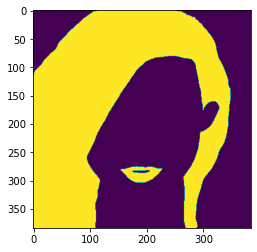

In [23]:
img_path = "/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebA-HQ-img/10071.jpg"
image = np.array(Image.open(img_path).convert("RGB"))/255
aug = seg_transforms(image=image)
image = aug["image"].unsqueeze(dim=0).to(DEVICE,dtype=torch.float)
preds = F.softmax(seg_model(image), dim=1)
preds = preds.argmax(dim=1)
fig,a =  plt.subplots(1,2,figsize=(10,20))
image = image.permute(0,2,3,1).cpu().numpy()[0]*255.0
originalImage = image.astype(np.uint8)
image = image.astype(np.uint8)
preds = preds.cpu().numpy()[0]
a[0].imshow(originalImage)
a[0].set_xticks([])
a[0].set_yticks([])
a[1].imshow(preds)
a[1].set_xticks([])
a[1].set_yticks([])
plt.show()
hair = np.where(preds == 1)
mask = np.where(preds == 1, 1, 0)
image[hair] = [153,76,0]
plt.imshow(mask)
plt.show()

399it [00:42,  9.40it/s]


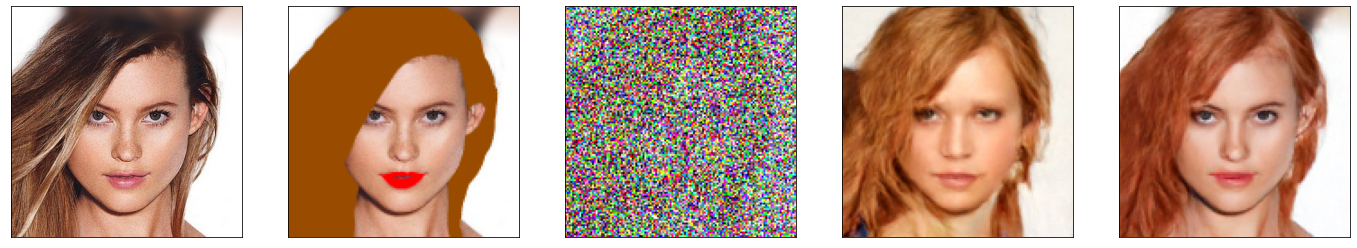

In [25]:
# trainer.addNoiseandDenoise(200,image)
trainer.addNoiseandDenoisewithAndWithoutMask(400,image,originalImage,mask)

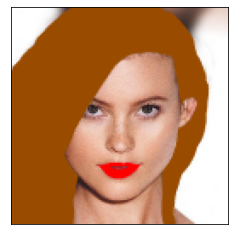

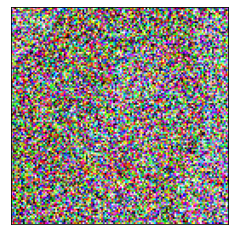

399it [00:21, 18.94it/s]


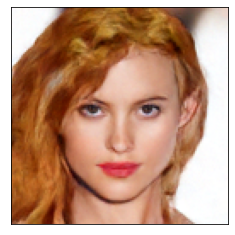

In [30]:
img = trainer.addNoiseandMaskedDenoise(400,image,mask)

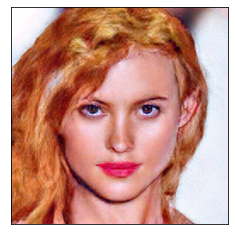

In [31]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

superResolutionTransform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

image = superResolutionTransform(img)
image = torch.unsqueeze(image, 0).to(DEVICE)
HR_Image = generator(image)
HR_Image = HR_Image.detach().cpu()
HR_Image = (HR_Image.clamp(-1, 1) + 1) / 2

HR_Image = HR_Image[0].permute(1, 2, 0).numpy() * 255
HR_Image = HR_Image.astype(np.uint8)
plt.imshow(HR_Image)
plt.xticks([], [])
plt.yticks([], [])
plt.show()